# Machine Learning Group Project 

User game rating prediction & systematic discount offering on Steam. Project developed by Team XX composed by:
| Student Name | Student Number | Class Group |
| --- | --- | --- |
| **Alessandro Maugeri** | 53067 | TA |
| **Frank Andreas Bauer** | XXXX | XX |
|  **Johannes Rahn** | 53958 | TB |
| **Nicole Zoppi** | XXXX | XX |
| **Yannick von der Heyden** | 53629 | TA |

## Importing Packages 

In [24]:
import ast
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import igraph as ig
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import concurrent.futures

## Reading DataFrame

In [25]:
final_df = pd.read_csv("data/final_df.csv")
final_df.head()

,app_id,helpful,funny,date,y,hours,user_id,review_id,title,date_release,...,publisher,required_age,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,products,reviews
0,304390,4,0,2017-02-17,False,11.5,1098,1,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,269,1
1,304390,2,0,2017-03-23,False,180.6,140776,26,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,110,2
2,108600,0,0,2022-01-17,False,132.2,140776,2349519,Project Zomboid,2013-11-08,...,The Indie Stone,0,Indie;RPG;Simulation;Early Access,Early Access;Survival;Zombies,0,658,701,500000-1000000,110,2
3,304390,0,0,2017-02-25,False,5.0,3904802,191,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,17,1
4,304390,4,0,2021-04-25,False,42.5,4222787,203,FOR HONOR™,2017-02-13,...,Ubisoft,0,Action,Medieval;Action;Swordplay,0,951,696,2000000-5000000,951,16


## Data Exploration

In [ ]:
final_df.shape

In [5]:
total_nans = final_df.isna().sum().sum()
print(f"Total NaNs in the final_df DataFrame: {total_nans}")

Total NaNs in the final_df DataFrame: 0


In [ ]:
# describe final_df
final_df.describe(percentiles=[.1, .25, .5, .75, .9]).round(2).T

**Correlation Matrix**

In [ ]:
# correlations between different variables, such as price and rating, user reviews and helpful votes, or hours played and recommendation status.

df_analyze = final_df[['price_final', 'rating', 'user_reviews', 'helpful', 'hours', 'y']]

# Convert rating column to numerical values
rating_map = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4,
    'Mostly Positive': 3,
    'Mixed': 2,
    'Mostly Negative': 1,
    'Very Negative': 0
}
df_analyze['rating'] = df_analyze['rating'].map(rating_map)

# Convert is_recommended column to binary values
df_analyze['y'] = df_analyze['y'].map({True: 1, False: 0})

# Calculate the correlation matrix
corr_matrix = df_analyze.corr()

# Setting seaborn style
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(10, 8))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


As expected, be observe the strongest positive correlations between is_recommended and rating and user_reviews and hours. Hours and is_recommended are also slightly correlated.
The final price seems to have a negative influence on user_reviews and the rating.

**Frequency Distribution of Final Prices**

In [ ]:
# frequency distribution of final prices

plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.hist(final_df['price_final'], bins=25, edgecolor='black', range=(0, 100))
plt.title('Frequency Distribution of Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Set the x-axis limits to 0 and 110
plt.show()

**Boxplot of Final Prices**

In [ ]:
# boxplot of final price

ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


**Frequency Distribution of Rating**

In [ ]:
# Plotting the frequency distribution of rating

plt.figure(figsize=(18, 10))
ax = sns.countplot(x='rating', data=final_df)
plt.title('Frequency Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

**Frequency Distribution of Recommendations**

In [ ]:
# Plotting the frequency distribution of number of recommendations

plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
ax = sns.countplot(x='y', data=final_df)
plt.title('Frequency Distribution of Recommendations')
plt.xlabel('Is Recommended')
plt.ylabel('Frequency')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

**Compatibility of Windows, Mac and Linux**

In [ ]:
# compatibility with different platforms

# Calculating the number of games compatible with each platform
platform_counts = final_df[['win', 'mac', 'linux']].sum().reset_index()
platform_counts.columns = ['Platform', 'Count']

plt.figure(figsize=(10, 5))

ax = sns.barplot(x='Platform', y='Count', data=platform_counts)
plt.title('Number of Games Compatible with Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Number of Games')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

In [ ]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

print(f"Number of games supporting only Windows: {win_only}")
print(f"Number of games supporting Windows and Mac: {win_mac}")
print(f"Number of games supporting Windows and Linux: {win_linux}")
print(f"Number of games supporting Windows, Mac, and Linux: {win_mac_linux}")
print(f"Number of games supporting only Mac: {mac_only}")
print(f"Number of games supporting only Linux: {linux_only}")

In [ ]:
# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Windows definitly dominates, when it comes to the number of games it supports. Most developers only develop for windows. However, there are still many games which run on windows, mac and linux. These results tell us that we should consider a users operating system, when recommending a game based on a user_id.

**Most popular Tags**

In [ ]:
import pandas as pd

# Read the data
final_df = pd.read_csv("data/final_df.csv")

# Split and count steamspy_tags and genres
steamspy_tags = final_df['steamspy_tags'].str.split(';', expand=True).stack().value_counts()
genres = final_df['genres'].str.split(';', expand=True).stack().value_counts()

# Print the most common steamspy_tags and genres
print("Most common steamspy_tags:\n", steamspy_tags.head(10))
print("\nMost common genres:\n", genres.head(10))

# Combine the split steamspy_tags and genres back into the DataFrame
final_df['steamspy_tags'] = final_df['steamspy_tags'].str.split(';')
final_df['genres'] = final_df['genres'].str.split(';')

# Calculate game popularity metrics, sales, and price_final
final_df['average_playtime'] = final_df['average_playtime'].astype(float)
final_df['reviews'] = final_df['reviews'].astype(int)
final_df['price_final'] = final_df['price_final'].astype(float)

# Group by steamspy_tags and genres, and calculate the average popularity, sales metrics, and price_final
tags_popularity = final_df.explode('steamspy_tags').groupby('steamspy_tags').agg({
    'average_playtime': 'mean',
    'reviews': 'sum',
    'price_final': 'mean'
}).sort_values('reviews', ascending=False)

genres_popularity = final_df.explode('genres').groupby('genres').agg({
    'average_playtime': 'mean',
    'reviews': 'sum',
    'price_final': 'mean'
}).sort_values('reviews', ascending=False)

# Print the popularity, sales metrics, and price_final for the most common steamspy_tags and genres
print("\nPopularity, sales metrics, and price_final by steamspy_tags:\n", tags_popularity.head(10))
print("\nPopularity, sales metrics, and price_final by genres:\n", genres_popularity.head(10))


Games with the tags "multiplayer", "open world", "survival", "free to play" and "simulation" are the most popular ones based on the number of tags. 

The most popular genres are "action", "adventure", " indie", "simulation" and "RPG".

We also observe the impact of tags on game popularity and sales. 

The tags "FPS" and "multiplayer" lead to the longest average playtime. 
Games with the tags "mulitplayer" and "open world" have the most reviews. 
Games with the tags "RPG" and "Survial" have the higest final price.

Among genres, "free to play" has the highest average playtime. "Action" has the most reviews and "strategy" the highest final price.

**Trends in game releases, user reviews, and ratings over time**

In [ ]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].sum()
avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Game Releases and User Reviews Over Time')
plt.show()

plt.plot(avg_ratings_by_year.index, avg_ratings_by_year)
plt.xlabel('Year')
plt.ylabel('Average Ratings')
plt.title('Average Ratings Over Time')
plt.show()

On average, the number of game releases has increased from 2006 to 2022. There where several drop in 2013, 2018 and 2020. The last drop is most likely due to the Covid-19 pandemic. User started reviewing games since 2010. The number of reviews has strongly increased since then.

The average ratings over time have decreased from 93 in the year 2010 to a rating of 84 in the year 2022. This could potentially indicate that the quality in games has also decreased and user are less satisfied with their games.

## Feature Engineering

**Elapsed Time:** A new feature which tracks the amount of time that has elapsed between the game's release and the review being logged. This could be interested because people who purchase a game right after its release are likely to be larger fans of the genre or franchise.

In [ ]:
final_df["elapsed_time"] = final_df["date"] - final_df["date_release"]

**Relative Recommendation:** Find the rate at which users rated a game positively (out of the count of games they have rated). Then, find for each review whether a recommendation is in line with user's typical reviews or not.

In [ ]:
# Count the number of reviews per user and rename column
usr_rating_count = final_df[["user_id","y"]].groupby("user_id").count()
usr_rating_count.rename(columns = {"y":"review_count"}, inplace = True)

# Find the number of positive reviews
usr_rating_count["positive_reviews"] = final_df[["user_id","y"]].groupby("user_id").sum()

# Find how many reviews out of total are positive
usr_rating_count["positive_rate"] = usr_rating_count["positive_reviews"] / usr_rating_count["review_count"]

In [ ]:
# Merge review_count and positive_rate to the final_df
final_df = final_df.merge(usr_rating_count.reset_index()[["user_id", "review_count", "positive_rate"]], 
                          how = "left", on = "user_id")

# Use these to create an ulterior feature with recommendation relative to average recommendation
final_df["relaitve_rec"] = (final_df["y"] - final_df["positive_rate"])

**Tendency to Review:** People who review more often tend to...

In [ ]:
# Find Review Tendency
final_df["review_tendency"] =  final_df["reviews"] /final_df["products"] 

# Find Tendency Relative to Median Because of Low Values
final_df["rel_review_tendency"] = (final_df["review_tendency"] - final_df["review_tendency"].median())/ final_df["review_tendency"].median()

**Positive & Negative Reviews:** Here we calculate the number of positive and negative reviews for each game. This is done through the positive_ratio column.

In [ ]:
final_df["positive_reviews"] = final_df["positive_ratio"] * final_df["user_reviews"]
final_df["negative_reviews"] = (1 - final_df["positive_ratio"]) * final_df["user_reviews"]

In [ ]:
final_df.head(2)

## Final Dataset Exploration

In [ ]:
# We see how many positive and negative recommendations there are
print(df_recommendations["y"].value_counts())

# What is their ratio?
print("\nHow many positive reviews for each negative one?")
df_recommendations["y"].value_counts()[0]/df_recommendations["y"].value_counts()[1]

## Model Preparation

#### Logistic Regression Model

In [ ]:
# Consider balancing out data because of overwhelming positivity

In [26]:
# Only for development
final_df = final_df.sample(n=400000, random_state=1)

### Network Analytics

In the following code we create an undirected graph representing relationships between video games based on users that reviewed both games. Each vertex in the graph corresponds to a unique video game, and an edge is added between two vertices if there are users who reviewed both games. This graph allows us to analyze relationships between video games and potentially discover interesting patterns, such as clusters of related applications, highly connected applications, or correlations between graph properties and other features of the dataframe.

In addition to vertices and edges, the graph stores various attributes for both vertices and edges. For vertices, attributes include game information such as title, release date, publisher, genres, and more. For edges, attributes include common user IDs, as well as other properties like helpfulness, funniness, date, recommendation status, hours played, user IDs, and review IDs. By attaching these attributes, the graph becomes a rich data structure that can be used for various analyses and predictions.

The code utilizes parallelization to improve the efficiency of constructing the graph. The add_edges_parallel function employs the ThreadPoolExecutor from the concurrent.futures module to concurrently compute common users and the specified columns for each app_id pair. This parallelization helps speed up the graph construction process, making it more feasible to work with large datasets. Once the graph is constructed, it can be used for a variety of purposes, such as predicting various graph properties using machine learning algorithms or finding patterns and relationships in the application dataset which can be utilized later.

In [27]:
### Undirected approach

In [28]:
def compute_common_users_and_columns(app_id_source, app_id_target, final_df):
    common_rows = final_df[(final_df['app_id'] == app_id_source) | (final_df['app_id'] == app_id_target)]

    common_users = list(common_rows['user_id'])
    columns = {col: list(common_rows[col]) for col in ['helpful', 'funny', 'date', 'y', 'hours', 'user_id', 'review_id']}

    return common_users, columns

def add_edges_parallel(graph, common_app_df, final_df):
    edges = []
    edge_common_users = []
    edge_columns = {col: [] for col in ['helpful', 'funny', 'date', 'y', 'hours', 'user_id', 'review_id']}

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []

        for _, row in common_app_df.iterrows():
            app_id_source = row['app_id_x']
            app_id_target = row['app_id_y']

            future = executor.submit(compute_common_users_and_columns, app_id_source, app_id_target, final_df)
            futures.append((app_id_source, app_id_target, future))

        for app_id_source, app_id_target, future in futures:
            source_vertex_id = app_id_to_vertex_id[app_id_source]
            target_vertex_id = app_id_to_vertex_id[app_id_target]
            common_users, columns = future.result()

            edges.append((source_vertex_id, target_vertex_id))
            edge_common_users.append(common_users)

            for col in edge_columns:
                edge_columns[col].extend(columns[col])

    graph.add_edges(edges)
    graph.es["common_user_ids"] = edge_common_users
    for col in edge_columns:
        graph.es[col] = edge_columns[col]

In [29]:
## Executing undircted graph

G = ig.Graph(directed=False)

unique_app_ids = final_df['app_id'].unique()
G.add_vertices(len(unique_app_ids))

app_id_to_game_info = {app_id: game_info for app_id, game_info in zip(final_df['app_id'], final_df.to_dict('records'))}
G.vs["game_info"] = [app_id_to_game_info[app_id] for app_id in unique_app_ids]

app_id_to_vertex_id = {app_id: idx for idx, app_id in enumerate(unique_app_ids)}

game_info_columns = ["title", "date_release", "publisher", "required_age",
                     "genres", "steamspy_tags", "achievements", "average_playtime",
                     "median_playtime", "owners", "products", "reviews"]

for col in game_info_columns:
    G.vs[col] = [game_info[col] for game_info in G.vs["game_info"]]

user_app_pairs = final_df[['user_id', 'app_id']]

common_app_df = user_app_pairs.merge(user_app_pairs, on='user_id')

common_app_df = common_app_df[common_app_df['app_id_x'] < common_app_df['app_id_y']]

add_edges_parallel(G, common_app_df, final_df)

In [30]:
# Saving graph object to a file as creating the graph takes very long
import pickle

In [31]:
# Write graph to a file

with open("data/graph_undircted.pickle", "wb") as f:
    pickle.dump(G, f)

In [ ]:
# Read graph from file:
with open("data/graph.pickle", "rb") as f:
    G = pickle.load(f)

In [14]:
display(ig.plot(G))

In [17]:
subgraph.get_adjacency()

Matrix([[0, 14], [14, 0]])

#### Subgraph for specfic games

In [18]:
subgraph.get_edge_dataframe()

,source,target,common_user_ids,helpful,funny,date,y,hours,user_id,review_id
edge ID,,,,,,,,,,
0,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",0,0,2020-09-08,True,178.5,2310027,3196006
1,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",2,0,2021-07-12,True,421.5,817444,3952468
2,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",0,0,2020-10-19,True,256.8,3993070,3186429
3,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",0,0,2020-11-21,True,37.6,2917935,4389950
4,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",0,0,2018-08-05,True,292.1,3245244,2560645
5,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",0,0,2022-01-27,True,964.9,309939,3576190
6,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",0,0,2015-05-17,False,39.0,2870629,3122751
7,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",2,0,2018-11-22,True,603.9,2512375,3436831
8,0,1,"[5671050, 1019895, 3093119, 1633505, 894016, 4...",0,0,2020-08-08,True,158.1,3983550,209945


In [ ]:
def get_top_connected_subgraph(graph, app_id, top_n=10):
    # Find the vertex corresponding to the app_id
    app_vertex = next((v for v in graph.vs if v["game_info"]["app_id"] == app_id), None)
    
    if app_vertex is None:
        print(f"App ID {app_id} not found in the graph.")
        return None

    # Get the neighbors of the app_vertex sorted by edge weights (length of common_user_ids)
    neighbors = sorted(app_vertex.neighbors(), key=lambda v: len(graph.es[graph.get_eid(app_vertex, v)]["common_user_ids"]), reverse=True)
    
    # Take only the top_n neighbors
    top_neighbors = neighbors[:top_n]

    # Create a subgraph containing the app_vertex and its top_n connected nodes
    subgraph = graph.subgraph([app_vertex] + top_neighbors)
    
    return subgraph

In [34]:
# Degree
degree = G.degree()

# Betweenness Centrality
betweenness = G.betweenness(directed=True)

# Closeness Centrality
closeness = G.closeness(normalized=True)

# Eigenvector Centrality
eigenvector_centrality = G.eigenvector_centrality(directed=True)

# Clustering Coefficient
clustering_coefficient = G.transitivity_local_undirected(mode="nan")

# Diameter
diameter = G.diameter(directed=True)

# Average Path Length
average_path_length = G.average_path_length(directed=True)

In [35]:
# Extract graph features
features_df = pd.DataFrame({
    'app_id': [game_info['app_id'] for game_info in G.vs['game_info']],
    'degree': G.degree(),
    'betweenness': G.betweenness(directed=True),
    'closeness': G.closeness(normalized=True),
    'eigenvector_centrality': G.eigenvector_centrality(directed=True),
    'clustering_coefficient': G.transitivity_local_undirected(mode="nan"),
})
# Merge with the original node attributes
features_df = features_df.merge(final_df.drop_duplicates(subset='app_id'), on='app_id', how='left')

Interesting insights:
Eigenvector centrality: average playtime
betweenness: price_final

C:\Users\Johannes Rahn\AppData\Local\Temp\ipykernel_12620\2943526832.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = features_df.corr(method ='pearson')[['betweenness' ,'closeness' ,'eigenvector_centrality' ,'clustering_coefficient']]


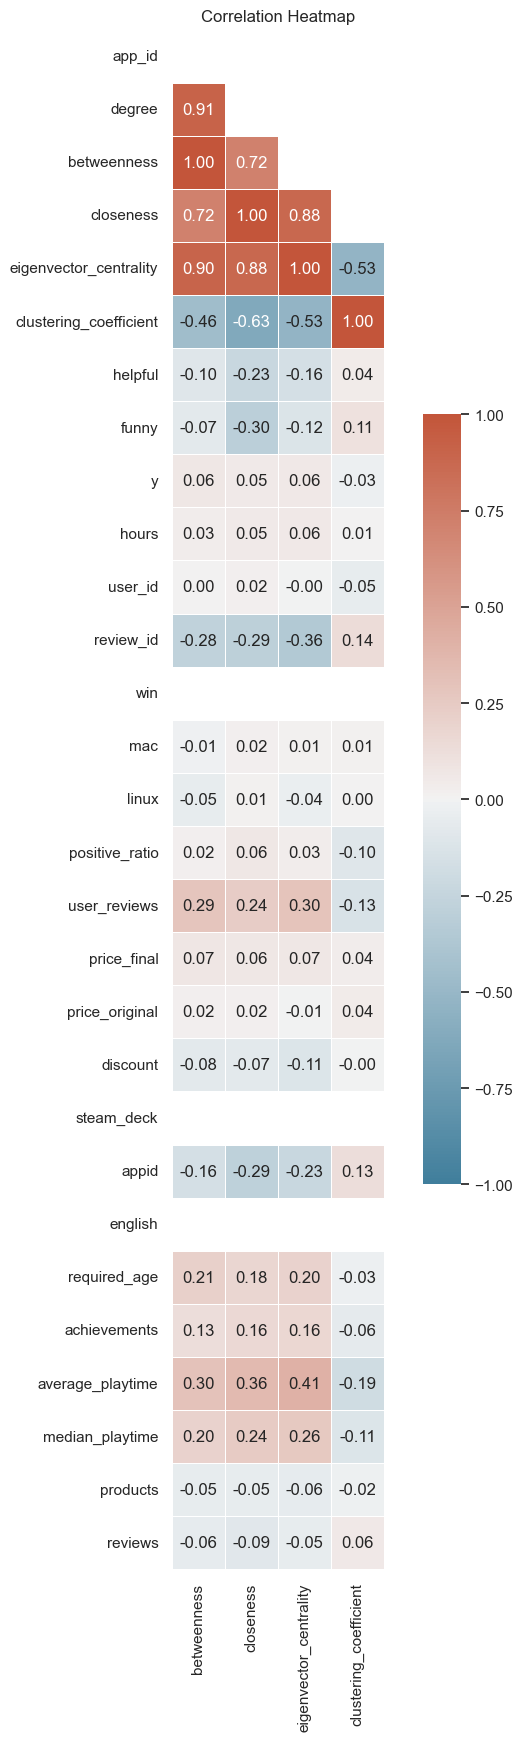

In [36]:
corr_mat = features_df.corr(method ='pearson')[['betweenness' ,'closeness' ,'eigenvector_centrality' ,'clustering_coefficient']]

# Setting seaborn style
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

f, ax = plt.subplots(figsize=(10, 20))


cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
G.vertex_attributes()

In [ ]:
# Set the weight of each edge
G.es['weight'] = [(G.degree(e.source) + G.degree(e.target))/10 for e in G.es]

# Draw the graph with node labels and edge weights
visual_style = {'vertex_size': 10, 'edge_color': 'gray', 'edge_width': G.es['weight'], 
                'edge_curved' : False, 'layout' : G.layout_fruchterman_reingold(),
               'vertex_color' : G.es['genres']}
ig.plot(G, **visual_style)

['Rust', 'Fallout 4']


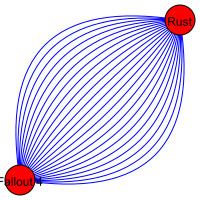

In [ ]:
app_id = 377160 

subgraph = get_top_connected_subgraph(G, app_id)

# Print the titles of the games in the subgraph
print([v["title"] for v in subgraph.vs])

# Plot the subgraph
if subgraph:
    # Map subgraph vertex indices back to original graph vertex indices
    original_vertex_indices = [G.vs.find(title=v["title"]).index for v in subgraph.vs]
    
    # Calculate edge widths using the original graph
    edge_widths = []
    for v1, v2 in subgraph.get_edgelist():
        original_v1 = original_vertex_indices[v1]
        original_v2 = original_vertex_indices[v2]
        edge_widths.append(len(G.es[G.get_eid(original_v1, original_v2)]["common_user_ids"]))

    visual_style = {
        'vertex_size': 30,
        'vertex_label': [v["title"] for v in subgraph.vs],
        'vertex_label_size': 12,
        'edge_color': 'blue',
        #'edge_width': edge_widths,
        'layout': subgraph.layout('kk'),
        'bbox' : (200, 200)
        
    }
    
    display(ig.plot(subgraph, **visual_style))
else:
    print("Subgraph not found.")

In [ ]:
# Set the weight of each edge
subgraph.es['weight'] = [subgraph.degree(e.source) + subgraph.degree(e.target) for e in subgraph.es]

# Draw the graph with node labels and edge weights
visual_style = {'vertex_size': 10, 'edge_color': 'gray', 'edge_width': G.es['weight'], 
                'edge_curved' : False, 'layout' : G.layout_fruchterman_reingold()}
ig.plot(subgraph, **visual_style)

In [ ]:
#### Graph Machine Learning:
G.vertex_attributes()

In [ ]:
G.edge_attributes()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_output):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_output)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [ ]:
def create_data_from_igraph(G):
    num_nodes = len(G.vs)
    torch.con
    node_features = torch.from_numpy(np.array(G.vs['game_info']))
    x = torch.tensor(node_features, dtype=torch.float)

    edge_list = np.array([e.tuple for e in G.es])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)
    return data

data = create_data_from_igraph(G)

In [ ]:
centrality = np.array(G.vs.degree())
eigenvector_centrality = np.array(G.eigenvector_centrality())
y = np.stack((centrality, eigenvector_centrality), axis=-1)
y = torch.tensor(y, dtype=torch.float)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
y = y.to(device)

model = GCN(num_node_features=data.num_node_features, num_hidden=64, num_output=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, y)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")
